# Convolutional Neural Network

This is code for a convolutional network written from scratch

First importing the dependencies:

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import ndimage 
from keras.datasets import mnist 
from tqdm import tqdm_notebook #used for progress bar - how far through training we are

Using TensorFlow backend.


Next, we need to get our data - we are using the MNIST handwritten digits dataset. Keras provides a helper function for us to load this data in. 

We then reshape the input so it is a 4D array of dimensions $(m,w,h,n_c)$ i.e $(m,28,28,1)$. 
To aid training, we normalise the input, so pixel values are in range [0,1] rather than [0,255].

We one-hot encode our labels y so it is a $(10,m)$ matrix.

Finally, we shuffle the data and return it.

In [2]:
def process_input(X,Y):
    X = np.reshape(X,(X.shape[0], 28,28,1))
    X= X/255 #normalise input features 
    Y = np.eye(10)[Y.reshape(-1)].T #Y.reshape(-1) flattens the input to a 1D array
    #in general np.eye(num_classes)[array].T will take a 1D array with m training examples, and 
    #one-hot encode it into a (num_classes,m) matrix
    
    idx = np.random.permutation(np.arange(X.shape[0])) #shuffle indices
    
    X = X[idx]
    Y = Y[:,idx]
    return X,Y

The training set consists of 60,000 examples, whilst the test set consists of 10,000 examples.
We can split the training set, so 10,000 of these examples are kept aside for our validation set.

In [3]:
(x_train_dev, y_train_dev), (x_test, y_test) = mnist.load_data()

x_train_dev, y_train_dev = process_input(x_train_dev, y_train_dev)

x_train, y_train = x_train_dev[:-10000], y_train_dev[:,:-10000]
x_dev, y_dev = x_train_dev[-10000:], y_train_dev[:,-10000:]

x_test , y_test = process_input(x_test , y_test)

Having done this, let's code up the forward and backward passes for the convolutional neural network.
We will look at the convolution, pooling and fully-connected layers separately.


## Convolution layer:

We are using stride 1 since in practice we typically do not use a higher stride in CNNs as this aggressively loses information, and we prefer to reduce dimensionality in the pooling layers.

### Forward pass: 

$$Z^{(m_i)}_{i,j,k}= \sum_a \sum_b \sum_c X^{(m_i)}_{i+a,j+b,c} * W_{a,b,c,k}$$

We decide whether we want to zero-pad the input to preserve dimensionality of input after convolution ("same") or if we don't want to zero-pad.

<em> Implementation details: </em>


<strong>ndimage.convolve</strong> takes inputs two n-d arrays and performs an n-dimensional convolution operation on it. So for a 2d convolution it computes: 
 $$ \sum_a \sum_b  X^{(m_i)}_{i-a,j-b} * W_{a,b}$$

Since we want to perform a 2d convolution, we pass in 2d slices of the input, and sum across the depth of the input. Technically in a mathematical convolution, the filter is flipped (hence $i-a, j-b$ not  $i+a, j+b$) so we flip the filter beforehand to cancel out the reflection done by <strong>ndimage.convolve</strong>.



One subtlety is that <strong>ndimage.convolve</strong> starts convolution from centre of kernel and zero pads but we don't want this since we want to manually decide if we want to pad or not. So we ignore the edges of the output with a slice <em> [ f//2:-(f//2), f//2:-(f//2) ] </em>.




In [4]:
def conv_forward(x,w,b,padding="same"):
    if padding=="same": 
        pad = (w.shape[0]-1)//2
    else: #padding is valid - i.e no zero padding
        pad =0 
    n = (x.shape[1]-w.shape[0]+2*pad) +1 #ouput width/height
    
    y = np.zeros((x.shape[0],n,n,w.shape[3])) #output array
    
    #pad input
    x_padded = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),'constant', constant_values = 0)
    
    #flip filter to cancel out reflection
    w = np.flip(w,0)
    w = np.flip(w,1)
    
    f = w.shape[0] #size of filter
        
    for m_i in range(x.shape[0]): #each of the training examples
        for k in range(w.shape[3]): #each of the filters
            for d in range(x.shape[3]): #each slice of the input 
                y[m_i,:,:,k]+= ndimage.convolve(x_padded[m_i,:,:,d],w[:,:,d,k])[f//2:-(f//2),f//2:-(f//2)] #sum across depth
             
    y = y + b #add bias (this broadcasts across image)
    return y

### Backward pass:
   The backwards pass is a little more involved. The equations for the derivatives are as follows:
   
$$ \frac{\partial{J}}{\partial{W_{a,b,c,k}} } = \frac{1}{m} \sum_{m_i} \sum^{f-a}_{i=a} \sum^{f-b}_{j=b} \frac{\partial{J}}{\partial{Z^{(m_i)}_{i,j,k}} } * X^{(m_i)}_{i+a,j+b,c}$$
 
$$ \frac{\partial{J}}{\partial{b_{k}} } = \frac{1}{m} \sum_{m_i} \sum_i \sum_j  \frac{\partial{J}}{\partial{Z^{(m_i)}_{i,j,k}} }$$
 
$$ \frac{\partial{J}}{\partial{X^{(m_i)}_{i,j,c}} } = \sum_k \sum_a \sum_b  \frac{\partial{J}}{\partial{Z^{(m_i)}_{i-a,j-b,k}} } * W_{a,b,c}$$   

Once again, we pad the input x, to replicate the input to the forward pass. One neat trick we can do for efficiency is to broadcast our operation for dW - by expanding across dimensions, we can compute an elementwise product across a $(m, i, j ,c, k)$ matrix, then sum along $m, i, j $ dimensions.

Note for dx, we pad dZ with zeros to ensure dx is same dimensions as x_padded, then apply a convolution (note in this case we <em>do</em> want the filter to be flipped) - we then finish by removing the padding, so it has same dimensions as x.

In [5]:
def conv_backward(dZ,x,w,padding="same"):
    m = x.shape[0]
    
    db = (1/m)*np.sum(dZ, axis=(0,1,2), keepdims=True)
    
    if padding=="same": 
        pad = (w.shape[0]-1)//2
    else: #padding is valid - i.e no zero padding
        pad =0 
    x_padded = np.pad(x,((0,0),(pad,pad),(pad,pad),(0,0)),'constant', constant_values = 0)
    
    #this will allow us to broadcast operations
    x_padded_bcast = np.expand_dims(x_padded, axis=-1) # shape = (m, i, j, c, 1)
    dZ_bcast = np.expand_dims(dZ, axis=-2) # shape = (m, i, j, 1, k)
    
    dW = np.zeros_like(w)
    f=w.shape[0]
    w_x = x_padded.shape[1]
    for a in range(f):
        for b in range(f):
            #note f-1 - a rather than f-a since indexed from 0...f-1 not 1...f
            dW[a,b,:,:] = (1/m)*np.sum(dZ_bcast*x_padded_bcast[:,a:w_x-(f-1 -a),b:w_x-(f-1 -b),:,:],axis=(0,1,2))  
    
    dx = np.zeros_like(x_padded,dtype=float) 
    Z_pad = f-1
    dZ_padded = np.pad(dZ,((0,0),(Z_pad,Z_pad),(Z_pad,Z_pad),(0,0)),'constant', constant_values = 0)  
    
    for m_i in range(x.shape[0]):
        for k in range(w.shape[3]):
            for d in range(x.shape[3]):
                dx[m_i,:,:,d]+=ndimage.convolve(dZ_padded[m_i,:,:,k],w[:,:,d,k])[f//2:-(f//2),f//2:-(f//2)]
    dx = dx[:,pad:dx.shape[1]-pad,pad:dx.shape[2]-pad,:]
    return dx,dW,db

### Pooling Layer:

We are using 2x2 patches with stride of 2 since this is pretty much the only setting for the hyperparameters used.
#### Forward pass:
  To compute the max/mean of each 2x2 patch we use a neat trick - we reshape the array then take the max/mean along the new axes - this is more efficient that scanning through the image with a for loop. 
  We keep track of the max value in a mask to route gradients through in the backward pass. 
  
 We expand the output array so it is of same dimensionality as the input then use <strong>np.isclose</strong> to compare the arrays elementwise and find the max value for each patch. 
 NB, we use  <strong>np.isclose</strong> over <strong>np.equal</strong> for tolerance of floating point error.
 
 For average pooling, the gradient is distributed equally.
 #### Backward pass:
 We expand the gradient then route the gradient based on the mask.

In [6]:
def pool_forward(x,mode="max"):
    x_patches = x.reshape(x.shape[0],x.shape[1]//2, 2,x.shape[2]//2, 2,x.shape[3])
    if mode=="max":
        out = x_patches.max(axis=2).max(axis=3)
        mask  =np.isclose(x,np.repeat(np.repeat(out,2,axis=1),2,axis=2)).astype(int)
    elif mode=="average": 
        out =  x_patches.mean(axis=3).mean(axis=4)
        mask = np.ones_like(x)*0.25
    return out,mask

In [7]:
def pool_backward(dx, mask):
    return mask*(np.repeat(np.repeat(dx,2,axis=1),2,axis=2))

### Fully Connected Layers

The fully connected layers are the same as the layers found in a feedforward neural net.
We use ReLU as an activation function for the FC hidden layers, and Softmax for the final layer.

#### Forward pass:

The equations are:

$$Z^{(l)}=W^{(l)}A^{(l-1)}$$
$$A^{(l)}=g(Z^{(l)})$$ (where $g(x) = ReLU(x)$) or alternatively for softmax, $$A^{(l)}=softmax(Z^{(l)})$$

In [8]:
def relu(x, deriv=False):
    if deriv:
        return (x>0)
    return np.multiply(x, x>0)

In [9]:
def fc_forward(x,w,b):
    return relu(w.dot(x)+b)


In [10]:
def softmax_forward(x,w,b):
    z = w.dot(x)+b
    z -= np.mean(z,axis=0,keepdims=True)
    a = np.exp(z) 
    a = a/np.sum(a,axis=0,keepdims=True)
    return a+1e-8

#### Backward pass:

For the final softmax layer:
$$\frac{\partial \mathcal{J} }{\partial Z^{(L)}} = Y_{pred} - Y$$ 
For the other FC layers:
$$ \frac{\partial \mathcal{J} }{\partial Z^{(l)}} = \frac{\partial \mathcal{J} }{\partial A^{(l)}}*g^{'}(Z^{(l)})$$ 

The other equations are the same:

$$ \frac{\partial \mathcal{J} }{\partial W^{(l)}} = \frac{1}{m}\frac{\partial \mathcal{J} }{\partial Z^{(l)}} A^{(l-1) T} $$

$$ \frac{\partial \mathcal{J} }{\partial b^{(l)}} = \frac{1}{m} \sum_{i = 1}^{m} \frac{\partial \mathcal{J} }{\partial Z^{(l)(i)}}$$

$$ \frac{\partial \mathcal{J} }{\partial A^{(l-1)}} = W^{(l) T} \frac{\partial \mathcal{J} }{\partial Z^{(l)}} $$



In [11]:
def fc_backward(dA,a,x,w,b):
    m = dA.shape[1]
    dZ = dA*relu(a,deriv=True)
    dW = (1/m)*dZ.dot(x.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx =  np.dot(w.T,dZ)
    return dx, dW,db

In [12]:
def softmax_backward(y_pred, y, w, b, x):
    m = y.shape[1]
    dZ = y_pred - y
    dW = (1/m)*dZ.dot(x.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx =  np.dot(w.T,dZ)
    return dx, dW,db

### Defining the model:

We are going to use a small CNN architecture

#### CONV->RELU-> CONV->RELU-> POOL -> CONV->RELU-> CONV->RELU-> FC -> SOFTMAX

First, a couple of helper functions to randomly initialise the weights and biases from a normal distribution. We multiply by 0.25 /  0.1 respectively to ensure weights are small, and we add a small positive bias so that the ReLU neurons are not clamped to zero and thus "die".

NB: if the weights are made too small then there is very little variance so symmetry is not really broken, resulting in the CNN assigning similar probabilities to all classes and not learning as a result. 

We use a small number of filters to reduce the computational cost of training.

In [13]:
def init_conv_parameters(f, n_c, k):
    
    return 0.25*np.random.normal(size=(f,f,n_c,k)), 0.15+np.random.rand(1,1,1,k)
                                                                      
def init_fc_parameters(n_x,n_y):
    return 0.1*np.random.normal(size=(n_y,n_x)),0.15+np.random.rand(n_y,1) #slight positive bias to prevent dead ReLU

In [14]:
def initialise_parameters():    
    parameters={}
    parameters["W_conv1"], parameters["b_conv1"] = init_conv_parameters(5, 1, 4)
    parameters["W_conv2"], parameters["b_conv2"] = init_conv_parameters(5, 4, 4)

    parameters["W_conv3"], parameters["b_conv3"] = init_conv_parameters(3, 4, 8)
    parameters["W_conv4"], parameters["b_conv4"] = init_conv_parameters(3, 8,16)

    parameters["W_fc1"],parameters["b_fc1"] = init_fc_parameters(16*49,128)
    parameters["W_softmax"],parameters["b_softmax"] = init_fc_parameters(128,10)

    return parameters


#### Forward propagation

Now for the forward propagation through the entire network. We store intermediate values in a cache to use in the backpropagation calculations.


In [15]:
def forward_prop(X,parameters):
    
    cache={}
    
    cache["z_conv1"] = conv_forward(X,parameters["W_conv1"], parameters["b_conv1"])
    cache["a_conv1"] = relu(cache["z_conv1"])

    cache["z_conv2"] = conv_forward(cache["a_conv1"],parameters["W_conv2"], parameters["b_conv2"])
    cache["a_conv2"] = relu(cache["z_conv2"])

    cache["z_pool1"], cache["mask_pool1"] = pool_forward(cache["a_conv2"])
    
 

    cache["z_conv3"] = conv_forward(cache["z_pool1"],parameters["W_conv3"], parameters["b_conv3"])
    cache["a_conv3"] = relu(cache["z_conv3"])
    
 

    cache["z_conv4"] = conv_forward(cache["a_conv3"],parameters["W_conv4"], parameters["b_conv4"] )
    cache["a_conv4"] = relu(cache["z_conv4"])
    
 
    cache["z_pool2"], cache["mask_pool2"] = pool_forward(cache["a_conv4"])


    cache["a_flatten"] = np.reshape(cache["z_pool2"], (cache["z_pool2"].shape[0],-1)).T

 
    cache["a_fc1"] = fc_forward( cache["a_flatten"],parameters["W_fc1"],parameters["b_fc1"])
    
    
    return softmax_forward(cache["a_fc1"],parameters["W_softmax"],parameters["b_softmax"]),cache

#### Loss function: 
We are using the cross entropy loss function with L2 regularisation:

$$ J(W....) = \frac{-1}{m} \sum_{m_i} \sum_c y^{(m_i)}_c \log{y^{(m_i)}_{pred_c}}  + \frac{\lambda}{2m}\sum_W  \left\| W \right\|^2$$

In [16]:
def loss_function(y_pred,y,parameters,lambd):
    m = y.shape[1]
    cost = (-1/m)*np.sum(y*np.log(y_pred))
    
    regularisation_term = 0
    for key in parameters:
        if "W_" in key: #all the weights
            regularisation_term += np.sum(np.square(parameters[key]))
    
    regularised_cost = cost + (lambd/(2*m))*regularisation_term
    
    return regularised_cost

#### Backpropagation

We save intermediate gradient values in the grad for visualisation purposes in training.

In [17]:
def backprop(X,Y,Y_pred,parameters,cache,lambd):
    grads = {}
    
    dA, grads["dW_softmax"],grads["db_softmax"] =softmax_backward(Y_pred, Y, parameters["W_softmax"],parameters["b_softmax"],cache["a_fc1"])

    dA, grads["dW_fc1"],grads["db_fc1"] = fc_backward(dA,cache["a_fc1"],cache["a_flatten"],parameters["W_fc1"],parameters["b_fc1"])
    
    dA = np.reshape(dA.T,cache["z_pool2"].shape)
    grads["dz_pool2"] = dA
    dA = pool_backward(dA, cache["mask_pool2"])
    
    dA = dA*relu(cache["z_conv4"],deriv=True)
    grads["dz_conv4"] = dA
    dA, grads["dW_conv4"],grads["db_conv4"] = conv_backward(dA,cache["a_conv3"],parameters["W_conv4"])
    
    dA = dA*relu(cache["z_conv3"],deriv=True)
    grads["dz_conv3"] = dA
    dA, grads["dW_conv3"],grads["db_conv3"] = conv_backward(dA,cache["z_pool1"],parameters["W_conv3"])
    
    grads["dz_pool1"] = dA
    dA = pool_backward(dA, cache["mask_pool1"])

    
    dA = dA*relu(cache["z_conv2"],deriv=True)
    grads["dz_conv2"] = dA
    dA, grads["dW_conv2"],grads["db_conv2"] = conv_backward(dA,cache["a_conv1"],parameters["W_conv2"])
    
    
    dA = dA*relu(cache["z_conv1"],deriv=True)
    grads["dz_conv1"] = dA
    grads["dx"], grads["dW_conv1"],grads["db_conv1"] = conv_backward(dA,X,parameters["W_conv1"])
    
    #regularisation term
    for key in grads:
        if "W" in key:
            grads[key]= grads[key]+ (lambd/X.shape[0])*parameters[key[1:]] 
    return grads        

### Training the model

Next, when training the model it is important to be able to tell if the model is learning. The evaluation metric we are using is accuracy since this is a classification task.

In [18]:
def accuracy(y_pred,y):
    preds = np.argmax(y_pred,axis=0) #number with highest probability
    truth = np.argmax(y,axis=0) #correct label is 1 rest are 0 so this will get correct label
    return np.mean(np.equal(preds,truth).astype(int)) #check for each one if classified correctly,then take mean

#### Numerical gradient calculation:

To check the backpropagation calculation is correct, we can numerically approximate the gradient at that point and compare it to the network's backprop gradient.
If the parameter we are perturbing is $p_i$ (could be a weight or a bias) then we use:

$$ \frac{\partial{J}}{\partial{p_i}} = \frac{J(..,p_i+\epsilon,..) - J(..,p_i-\epsilon,.)}{2 \epsilon} $$

to compute the gradient with respect to the parameter. 

For each of the weight/bias matrices, we sample 10 of the parameters in that matrix and average the numerical gradient and the backprop gradients. Then we look at the relative error, if this is very large we raise a flag to indicate that the backprop gradient is incorrect. We also raise a flag if the numerical gradient is zero, since this suggests a layer's ReLU neurons have died.

In [19]:
def backprop_checker(parameters,grads, x, y,lambd):
    epsilon = 1e-7
    rel_threshold = 10
    num_sample = 10
    flag = True #if backprop is correct
    print("Checking gradients...")
    for param in reversed(list(parameters.keys())): #look at last layers first
        print("Checking: " + param)
        dims = parameters[param].shape
        
        
        num_grad = 0
        backprop_grad = 0
        
        for _ in range(num_sample): #sample 10 neurons
            idx = np.zeros(len(dims))
            for i in range(len(dims)):
                idx[i] = np.random.randint(0,dims[i])
            idx = tuple(idx.astype(int))

            parameters[param][idx]= parameters[param][idx] + epsilon
            y_pred_plus = forward_prop(x,parameters)[0]
            J_plus = loss_function(y_pred_plus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx] - 2*epsilon

            y_pred_minus = forward_prop(x,parameters)[0]

            J_minus = loss_function(y_pred_minus,y,parameters,lambd)
            parameters[param][idx]= parameters[param][idx]+ epsilon

            num_grad += (J_plus-J_minus)/(2*epsilon)
            backprop_grad += grads["d"+param][idx]
            
            
        num_grad/=num_sample
        backprop_grad/=num_sample
        rel_error = abs((num_grad-backprop_grad)/num_grad)
        if rel_error>rel_threshold or num_grad==0:
            #print("J_plus: "+ str(J_plus))
            #print("J_minus: "+ str(J_minus))
            print("Numerical grad:" + str(num_grad))
            print("Backprop grad:" + str(backprop_grad))
            print("Relative error: " + str(rel_error))
            flag = False
            if(num_grad==0):
                print("DEAD RELU")
            else:
                print("Backprop calculation incorrect")
    print("Gradient check complete")
    assert(flag) #if not the backprop is massively out so kill training

We also would like to periodically view the outputs of the network during training, to manually spot any errors - e.g. a dead ReLU layer, or if the probabilities are very similar for all classes. We also might want to check that the intermediate values aren't getting too large, since this can lead to large gradients, and thus a chance of divergence or killing ReLU layers with a large weight update. 

We might also want to ensure the gradients have propagated through the network, as well as see how the weights of the filter have changed.

In [20]:
def visualisation(X_train_minibatch,Y_train_minibatch,cache, minibatch_grads, parameters, y_pred):
    fig2, ax = plt.subplots(3,8)
    #plot the activations of an example in the minibatch throughout the forward pass   
    m_i =  np.random.randint(0,X_train_minibatch.shape[0]) #pick random sample
    
    #for simplicity we sample the first filter in the layer
    ax[0,0].imshow(X_train_minibatch[m_i,:,:,0], cmap="gray")
    
    ax[0,1].imshow(cache["a_conv1"][m_i,:,:,0],cmap="gray") 
    ax[0,2].imshow(cache["a_conv2"][m_i,:,:,0],cmap="gray") 
    ax[0,3].imshow(cache["z_pool1"][m_i,:,:,0],cmap="gray") 
    ax[0,4].imshow(cache["a_conv3"][m_i,:,:,0],cmap="gray") 
    ax[0,5].imshow(cache["a_conv4"][m_i,:,:,0],cmap="gray") 
    ax[0,6].imshow(cache["z_pool2"][m_i,:,:,0],cmap="gray") 
    
    
    bar = ax[0,7].bar(np.arange(10),y_pred[:,m_i])
    bar[np.argmax(y_pred[:,m_i])].set_color('r')
    bar[np.argmax(Y_train_minibatch[:,m_i])].set_color('g')
    ax[0,7].set_ylim([0,1])
    
    ax[0, 0].set_title("Forward pass")
    ax[0, 6].set_title("Pred->")


    #backward pass for the filters
    
    ax[1,0].imshow(minibatch_grads["dx"][m_i,:,:,0],cmap="gray") 
    ax[1,1].imshow(minibatch_grads["dz_conv1"][m_i,:,:,0],cmap="gray")
    ax[1,2].imshow(minibatch_grads["dz_conv2"][m_i,:,:,0],cmap="gray") 
    ax[1,3].imshow(minibatch_grads["dz_pool1"][m_i,:,:,0],cmap="gray") 
    ax[1,4].imshow(minibatch_grads["dz_conv3"][m_i,:,:,0],cmap="gray") 
    ax[1,5].imshow(minibatch_grads["dz_conv4"][m_i,:,:,0],cmap="gray") 
    ax[1,6].imshow(minibatch_grads["dz_pool2"][m_i,:,:,0],cmap="gray") 
  
    bar = ax[1,7].bar(np.arange(10),(y_pred-Y_train_minibatch)[:,m_i])
    bar[np.argmax(y_pred[:,m_i])].set_color('r') #model prediction
    bar[np.argmax(Y_train_minibatch[:,m_i])].set_color('g') #correct label
    ax[1,7].set_ylim([-1,1])
    
    ax[1, 0].set_title("Backward pass")
    ax[1, 6].set_title("Error->")

    
    #weight matrices
    ax[2,0].imshow(parameters["W_conv1"][:,:,0,0], cmap="gray", interpolation='gaussian')
    ax[2,1].imshow(parameters["W_conv2"][:,:,0,0],cmap="gray", interpolation='gaussian') 
    ax[2,2].imshow(parameters["W_conv3"][:,:,0,0],cmap="gray", interpolation='gaussian') 
    ax[2,3].imshow(parameters["W_conv3"][:,:,1,1],cmap="gray", interpolation='gaussian') 
    ax[2,4].imshow(parameters["W_conv4"][:,:,0,0],cmap="gray", interpolation='gaussian') 
    ax[2,5].imshow(parameters["W_conv4"][:,:,1,1],cmap="gray", interpolation='gaussian') 
    ax[2,6].imshow(parameters["W_conv4"][:,:,2,2],cmap="gray", interpolation='gaussian') 
    ax[2,7].imshow(parameters["W_conv4"][:,:,3,3],cmap="gray", interpolation='gaussian') 
    
    
    ax[2, 0].set_title("W1")
    ax[2, 1].set_title("W2")
    ax[2, 2].set_title("W3")
    ax[2, 4].set_title("W4")
    
    fig2.canvas.draw()
   #check activations aren't blowing up or dead relu neurons
    print("MAX ACTIVATION OF LAYERS: ")
    for key in cache.keys():
        if "a_" in key:
            print(key + ": " + str(np.max(cache[key])))
            if np.max(cache[key])==0:
                backprop_checker(parameters,minibatch_grads, X_train_minibatch, Y_train_minibatch,lambd)


Finally, we tie it all together and train the model using <em> minibatch gradient descent with momentum </em>

we have that 
The update equations for the parameters are as follows:
$$ v_W = \beta*v_W + \frac{\partial \mathcal{J} }{\partial W} $$
$$ W = W - \alpha*v_W $$

where $\alpha$ is the learning rate parameter, $\beta=0.9$ typically and $v_W$ is the momentum term for that parameter, initialised to zeros.

In [21]:
%config InlineBackend.figure_format = 'retina'
%matplotlib notebook
def train_model(X_train, Y_train, X_dev, Y_dev,num_epochs,batch_size,lambd,learning_rate,parameters = initialise_parameters() ):
    train_costs = []
    train_evals = []
    dev_evals = []
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10, 3))
    
    ax1.set_xlabel('Number of iterations')
    ax1.set_ylabel('Error')
    ax1.set_title('Training Set Error')
    
    ax2.set_xlabel('Number of iterations')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Set Accuracy')
    
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Dev Set Accuracy')

    plt.tight_layout()
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    momentum = {}
    beta = 0.9
    for param in parameters:
        momentum[param] = np.zeros_like(parameters[param]) 

    
    for epoch in tqdm_notebook(range (num_epochs), total=num_epochs,desc="Number of Epochs"):
        print("Training the model, epoch: " + str(epoch+1))
        #cycle through the entire training set in batches
        for i in tqdm_notebook(range(0,X_train.shape[0]//batch_size), total =X_train.shape[0]//batch_size, desc = "Minibatch number"):
            
            
            #get the next minibatch to train on
            X_train_minibatch = X_train[i*batch_size:(i+1)*batch_size]
            Y_train_minibatch = Y_train[:,i*batch_size:(i+1)*batch_size]
            
            
            #perform one cycle of forward and backward propagation to get the partial derivatives w.r.t. the weights
            #and biases. Calculate the cost - used to monitor training
            y_pred, cache = forward_prop(X_train_minibatch,parameters)
            minibatch_cost = loss_function(y_pred,Y_train_minibatch,parameters,lambd)
            minibatch_grads = backprop(X_train_minibatch,Y_train_minibatch,y_pred,parameters, cache,lambd)
                            
         
            #update the parameters using gradient descent
            for param in parameters.keys():
                momentum[param] = beta *  momentum[param] + minibatch_grads["d"+param]
                parameters[param] = parameters[param] - learning_rate* momentum[param]
            
            train_costs.append(minibatch_cost)
            ax1.plot(train_costs)
            fig.canvas.draw()

            
            train_eval_metric = accuracy(y_pred,Y_train_minibatch)
            train_evals.append(train_eval_metric)
            ax2.plot(train_evals)
            fig.canvas.draw()
            
            #periodically output an update on the current cost and performance on the dev set for visualisation
            if(i%50 == 0):
                #visualise the activations and gradients
                visualisation(X_train_minibatch,Y_train_minibatch,cache, minibatch_grads, parameters, y_pred)
                print("\n \nTraining set error: "+ str(minibatch_cost))
                print("Training set accuracy: "+ str(train_eval_metric))
                y_dev_pred,_ = forward_prop(X_dev,parameters)
                dev_eval_metric = accuracy(y_dev_pred,Y_dev)
                dev_evals.append(dev_eval_metric)
                print("Accuracy on dev set: "+ str(dev_eval_metric))
                ax3.plot(dev_evals)
                fig.canvas.draw()
    print("Training complete!")
    #return the trained parameters 
    return parameters

Now let's train the model for an epoch (you can train it for longer as necessary, however 1 epoch is sufficient for decent results).

<IPython.core.display.Javascript object>


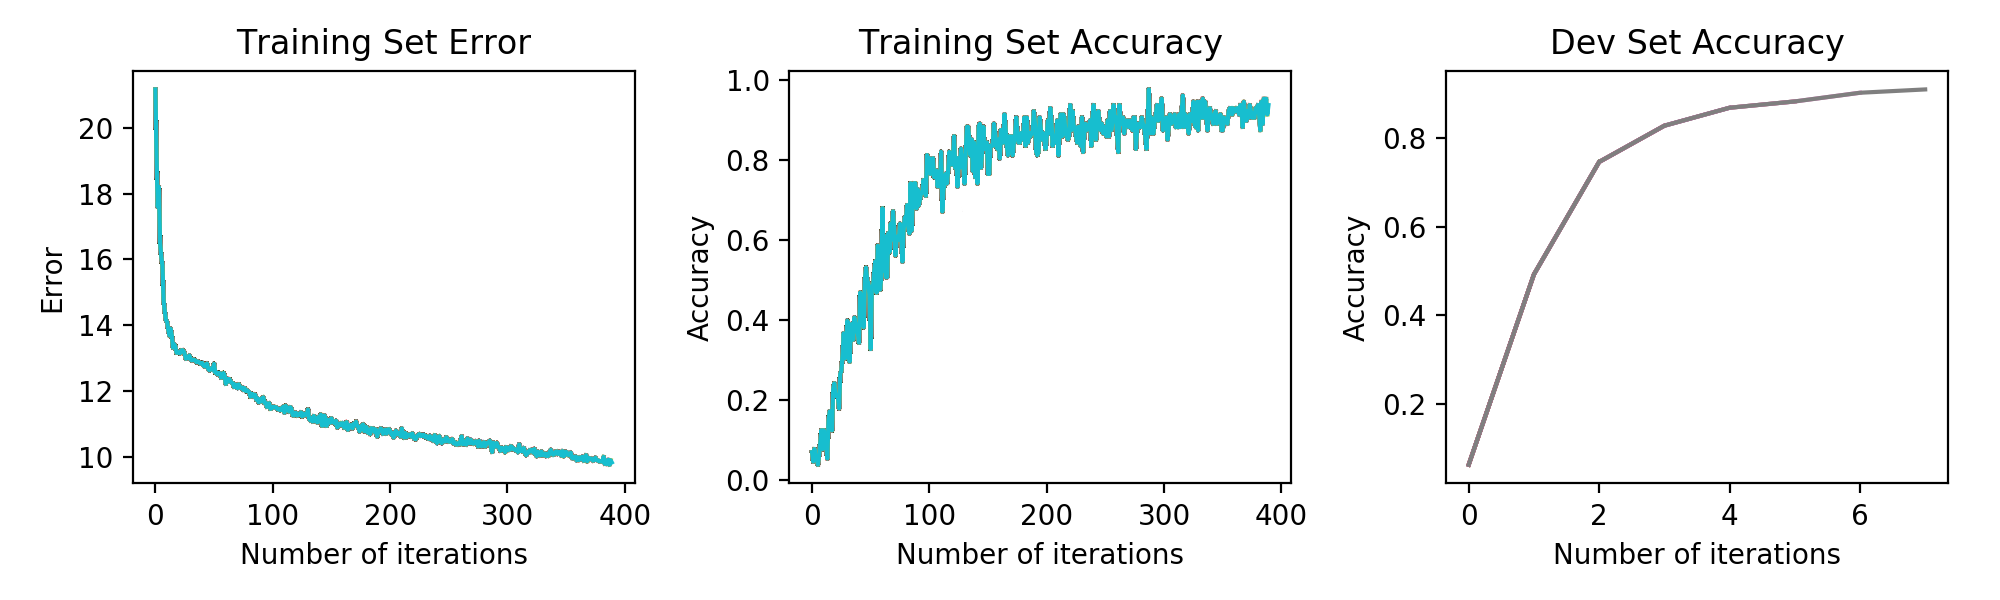

Training the model, epoch: 1


<IPython.core.display.Javascript object>


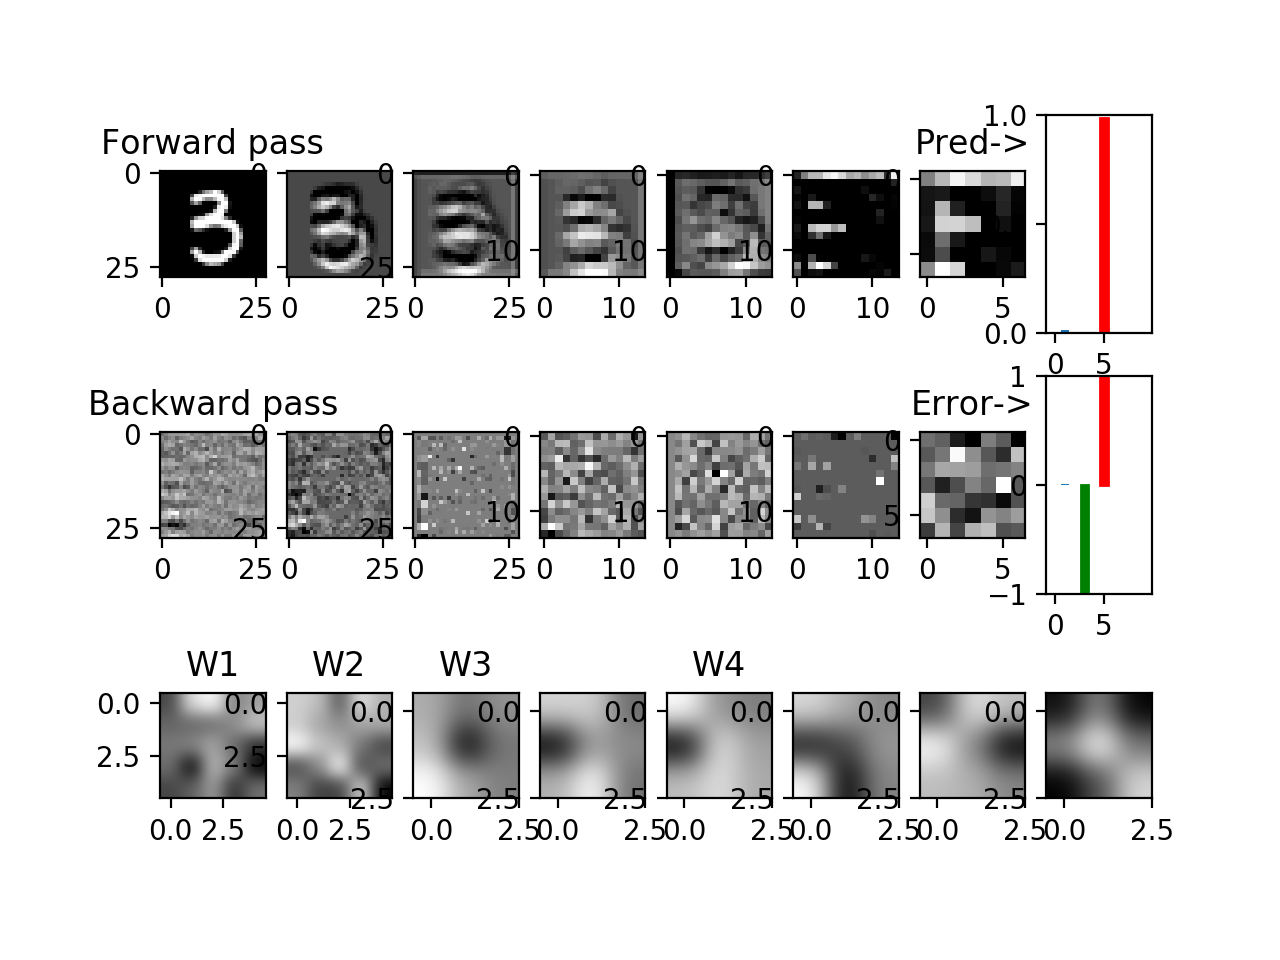

MAX ACTIVATION OF LAYERS: 
a_conv1: 2.95043726197523
a_conv2: 7.712649668829207
a_conv3: 11.918115985235238
a_conv4: 15.143736024018612
a_flatten: 15.143736024018612
a_fc1: 34.23838376469941

 
Training set error: 21.167437985228567
Training set accuracy: 0.0703125
Accuracy on dev set: 0.0632


<IPython.core.display.Javascript object>


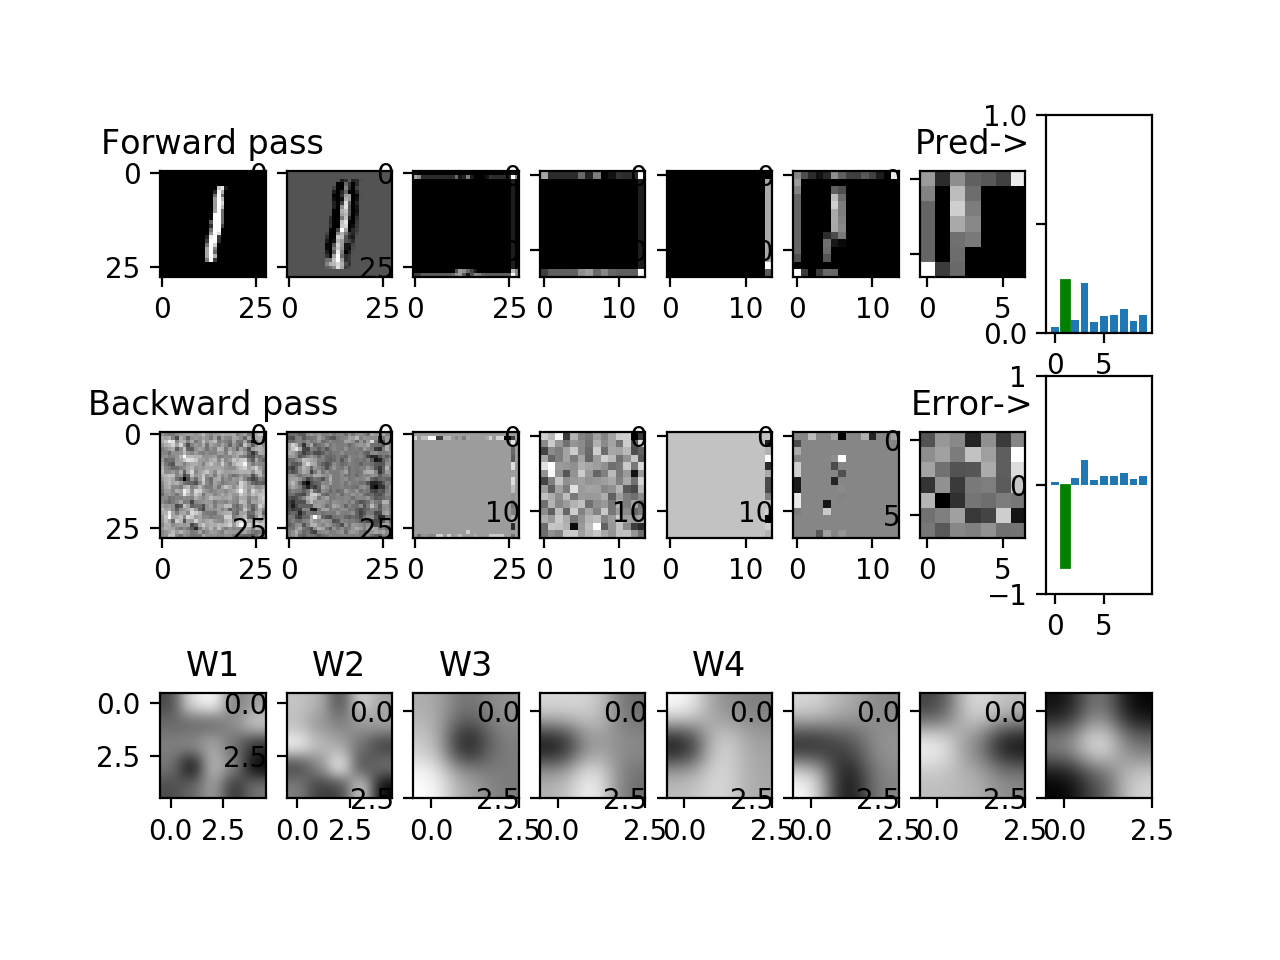

MAX ACTIVATION OF LAYERS: 
a_conv1: 2.5897723097766363
a_conv2: 8.145638012296159
a_conv3: 8.087123945648393
a_conv4: 5.356374837791083
a_flatten: 5.356374837791083
a_fc1: 8.58979221312192

 
Training set error: 12.81734089812353
Training set accuracy: 0.328125
Accuracy on dev set: 0.4921


<IPython.core.display.Javascript object>


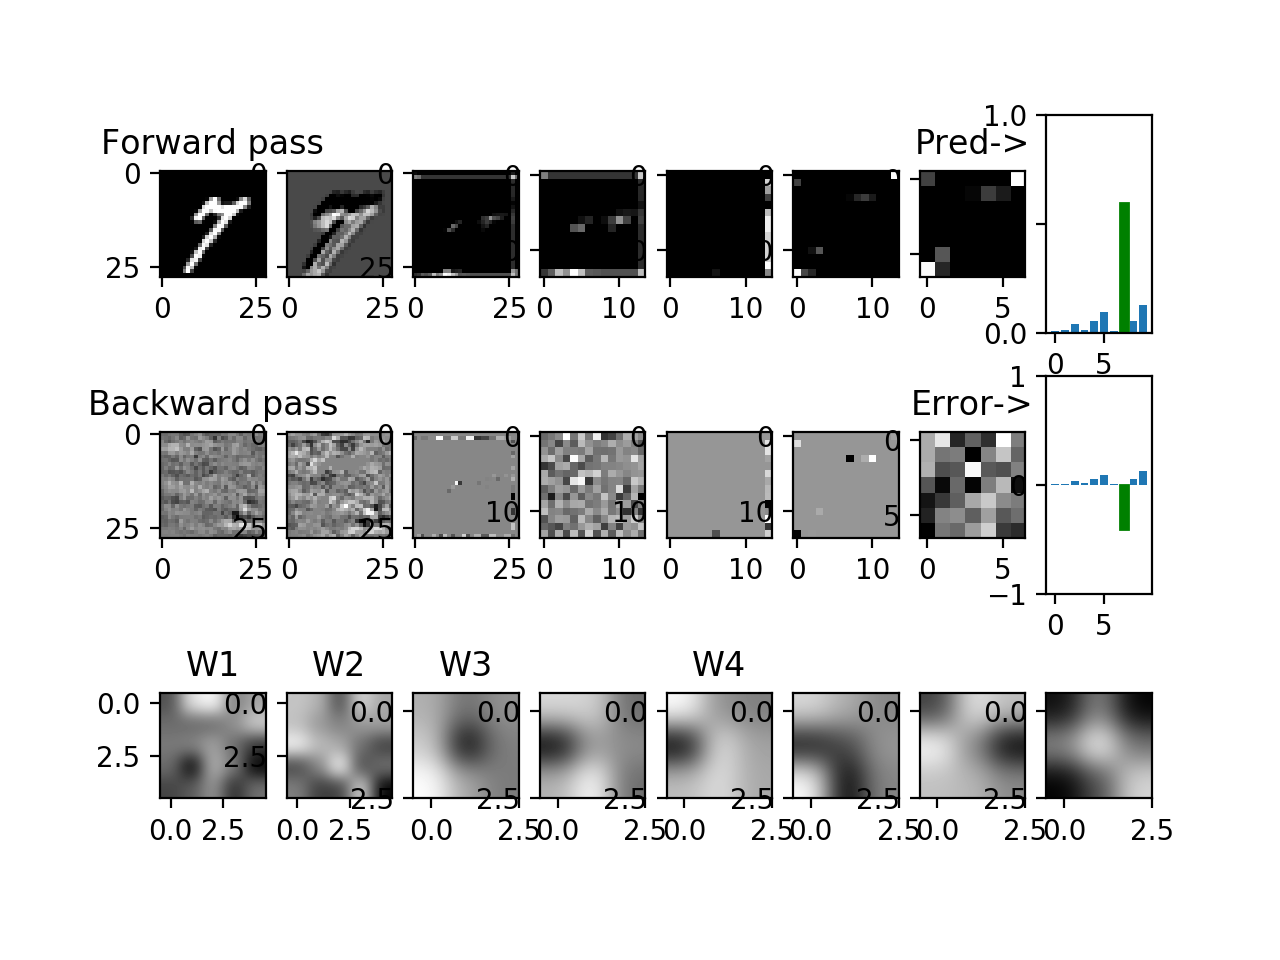

MAX ACTIVATION OF LAYERS: 
a_conv1: 2.530428000715633
a_conv2: 11.014511347589107
a_conv3: 10.746146811837638
a_conv4: 8.98396399701969
a_flatten: 8.98396399701969
a_fc1: 13.272550169410321

 
Training set error: 11.508565470689334
Training set accuracy: 0.8046875
Accuracy on dev set: 0.7457


<IPython.core.display.Javascript object>


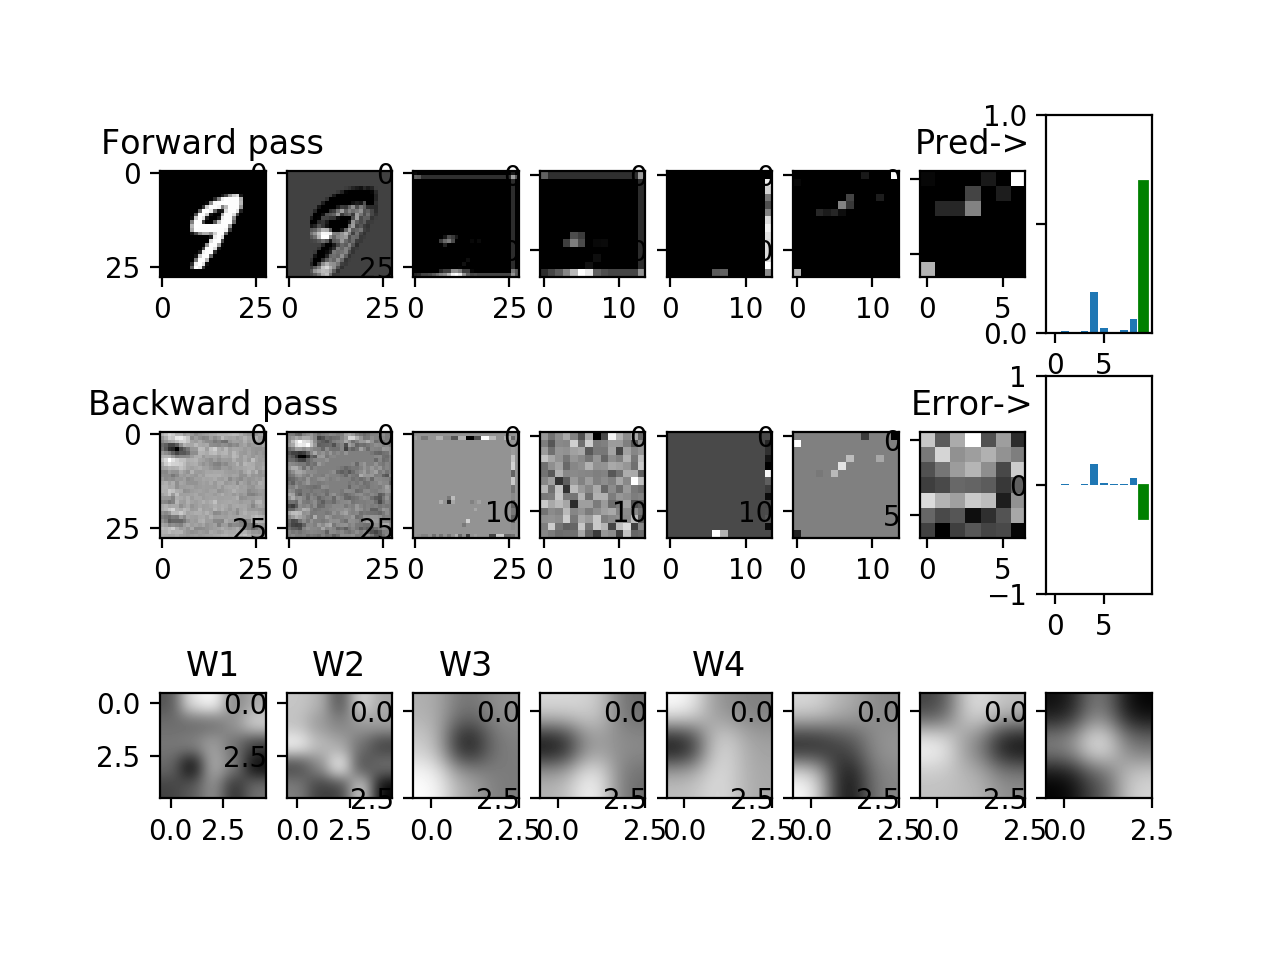

MAX ACTIVATION OF LAYERS: 
a_conv1: 2.631710149378686
a_conv2: 12.274382809114169
a_conv3: 14.139046434167398
a_conv4: 12.743565270585913
a_flatten: 12.743565270585913
a_fc1: 16.29559248272773

 
Training set error: 11.160665993535405
Training set accuracy: 0.765625
Accuracy on dev set: 0.8274


<IPython.core.display.Javascript object>


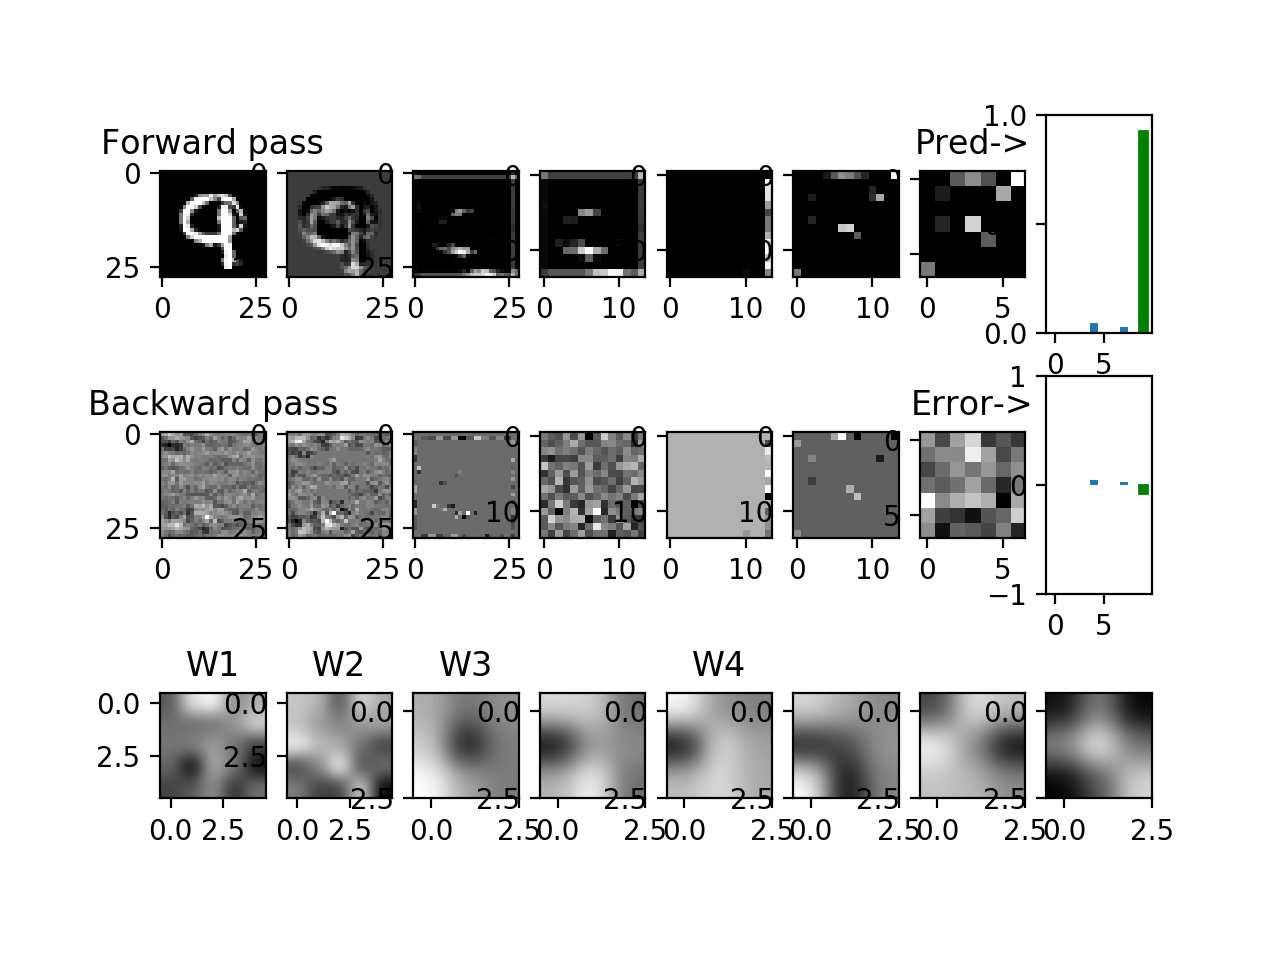

MAX ACTIVATION OF LAYERS: 
a_conv1: 2.7801525890416503
a_conv2: 11.85773333614222
a_conv3: 14.071342890042247
a_conv4: 13.250532347244963
a_flatten: 13.250532347244963
a_fc1: 18.04656759088485

 
Training set error: 10.777076721905287
Training set accuracy: 0.859375
Accuracy on dev set: 0.8679


<IPython.core.display.Javascript object>


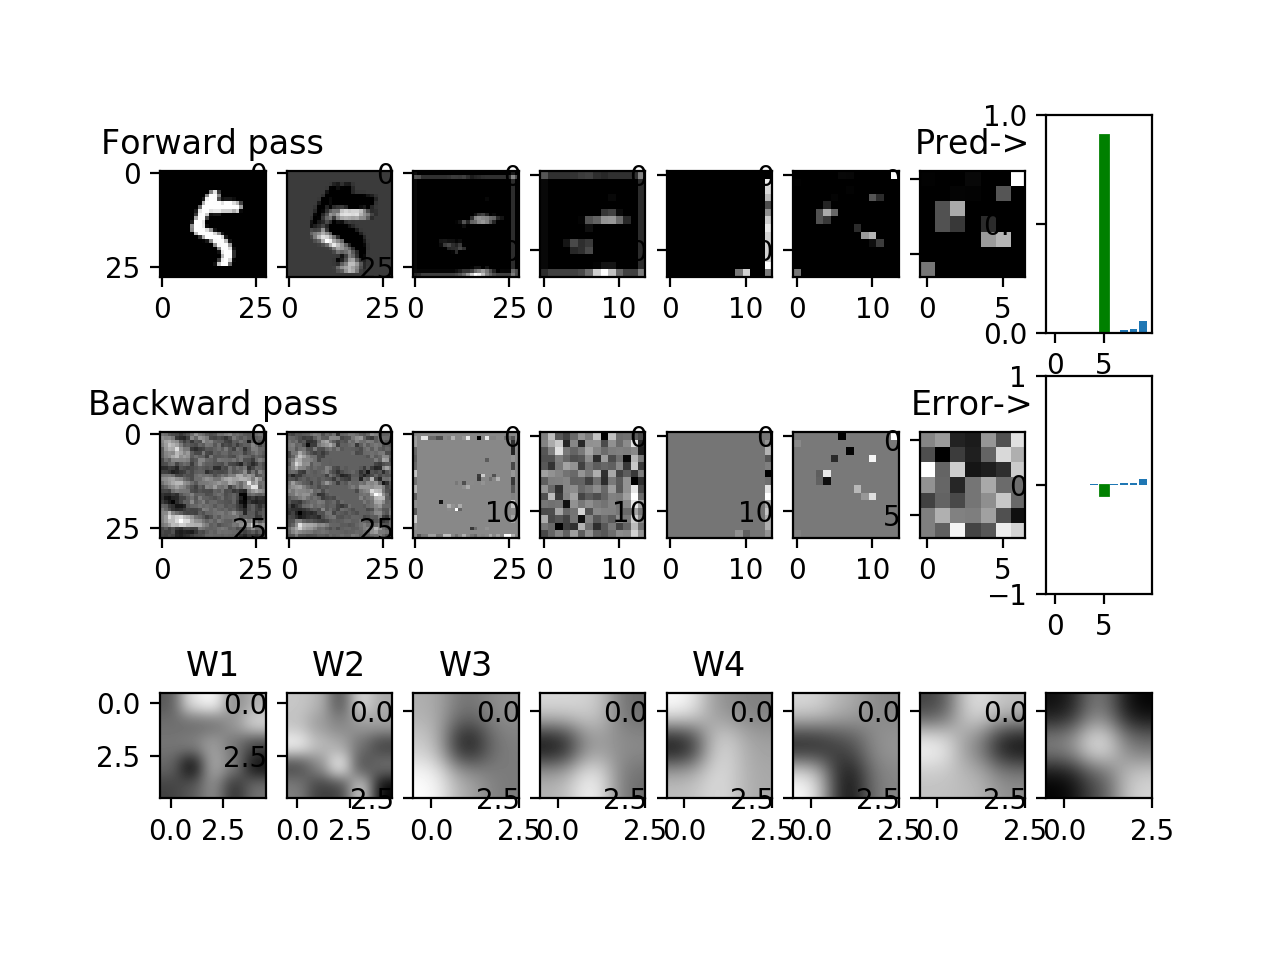

MAX ACTIVATION OF LAYERS: 
a_conv1: 2.671006970324433
a_conv2: 12.127122213738621
a_conv3: 15.859637729964595
a_conv4: 14.377450131808443
a_flatten: 14.377450131808443
a_fc1: 23.986273055264984

 
Training set error: 10.46030945690326
Training set accuracy: 0.8828125
Accuracy on dev set: 0.8821


<IPython.core.display.Javascript object>


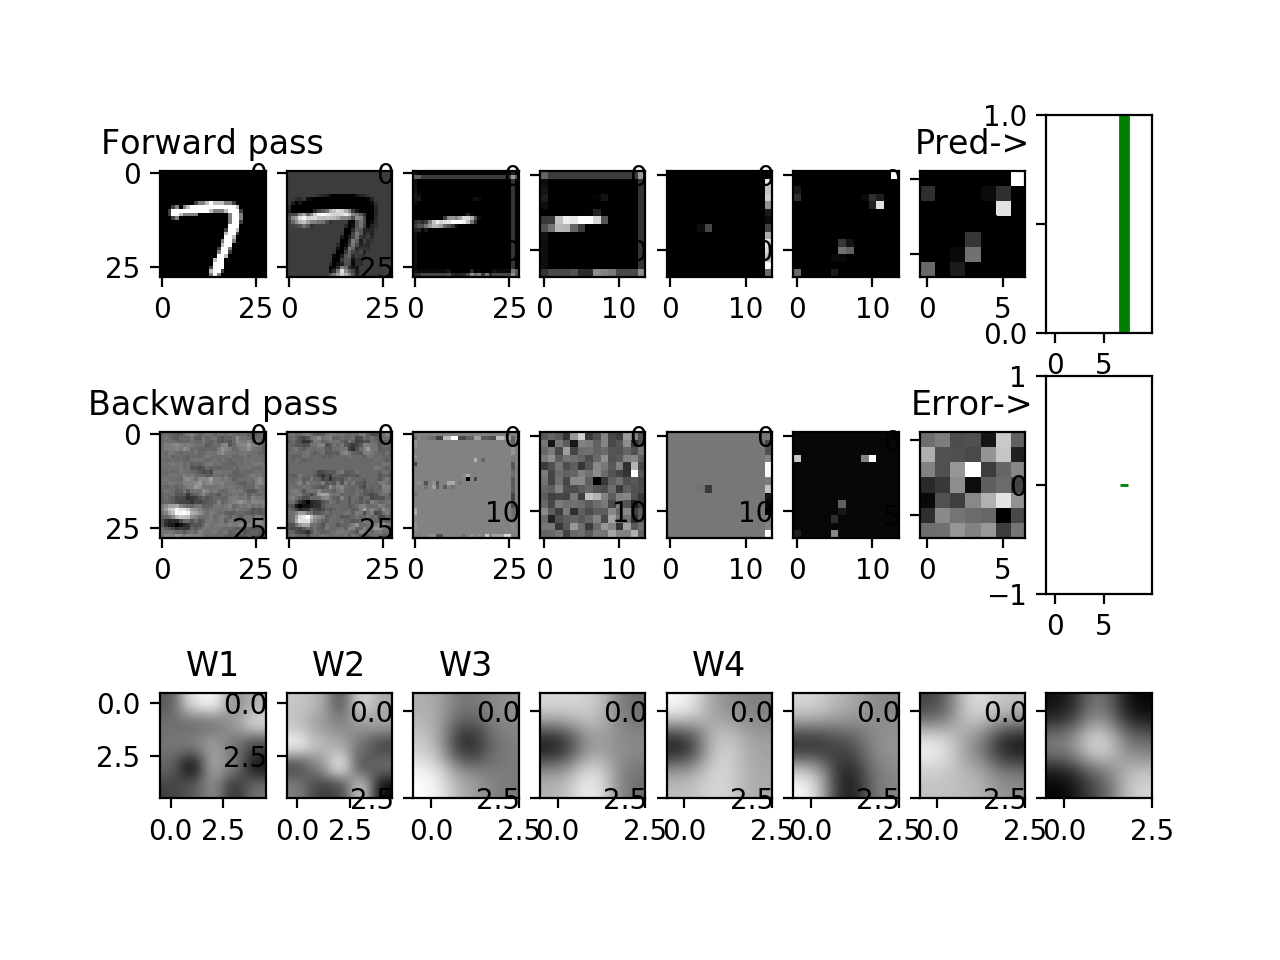

MAX ACTIVATION OF LAYERS: 
a_conv1: 2.8607338286041823
a_conv2: 11.789786806559494
a_conv3: 16.467561718217336
a_conv4: 15.252550527333765
a_flatten: 15.252550527333765
a_fc1: 19.679458215575874

 
Training set error: 10.198822027181256
Training set accuracy: 0.8984375
Accuracy on dev set: 0.9017


<IPython.core.display.Javascript object>


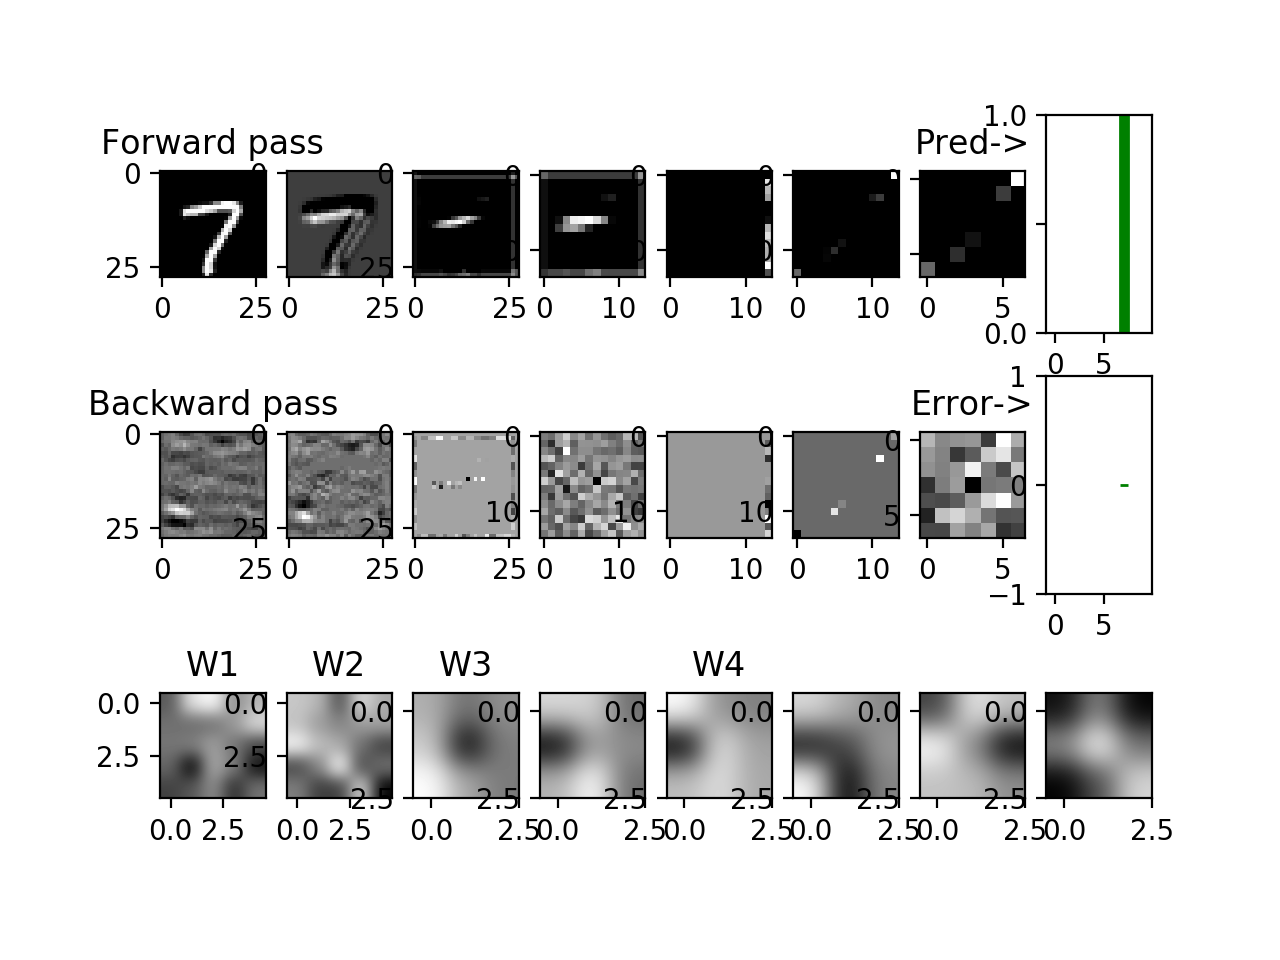

MAX ACTIVATION OF LAYERS: 
a_conv1: 2.888769459877312
a_conv2: 12.138361077177871
a_conv3: 17.246724342790742
a_conv4: 16.4137268491562
a_flatten: 16.4137268491562
a_fc1: 19.62281476632915

 
Training set error: 10.14579469503253
Training set accuracy: 0.875
Accuracy on dev set: 0.9092

Training complete!


In [22]:
parameters =train_model(x_train,y_train,x_dev,y_dev,
                        num_epochs=1,batch_size=128,lambd=2.5,learning_rate=1e-3)

In [24]:
def grid(i,j):
    ax = plt.subplot2grid((8, 8), (i, j))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def predict(X_test,parameters,Y_test):
    
    m_i =  np.random.randint(0,X_test.shape[0]) #pick random sample
    x = np.expand_dims(X_test[m_i], axis=0)
    y = np.expand_dims(Y_test[:,m_i], axis=1)
    y_pred, cache = forward_prop(x,parameters)
    fig, ax = plt.subplots(squeeze=False,figsize=(9,9))
    

    fig.suptitle('Visualisation of the internals of a CNN')
    #plot the activations of the example throughout the forward pass   
    
    grid(0,3).imshow(x[0,:,:,0], cmap="gray")
    
    for i in range(4):
        grid(1,2+i).imshow(cache["a_conv1"][0,:,:,i],cmap="gray")
        grid(2,2+i).imshow(cache["a_conv2"][0,:,:,i],cmap="gray")

    for i in range(8):
        grid(3,i).imshow(cache["a_conv3"][0,:,:,i],cmap="gray")
        grid(4,i).imshow(cache["a_conv4"][0,:,:,i],cmap="gray")  
        grid(5,i).imshow(cache["a_conv4"][0,:,:,i+8],cmap="gray")  
        grid(6,i).imshow(np.repeat(cache["a_fc1"][16*i:(i+1)*16],4, axis=1).T,cmap="gray")
    
    bar = grid(7,3).bar(np.arange(10),y_pred[:,0])
    bar[np.argmax(y_pred[:,0])].set_color('r')
    bar[np.argmax(y[:,0])].set_color('g')



<IPython.core.display.Javascript object>


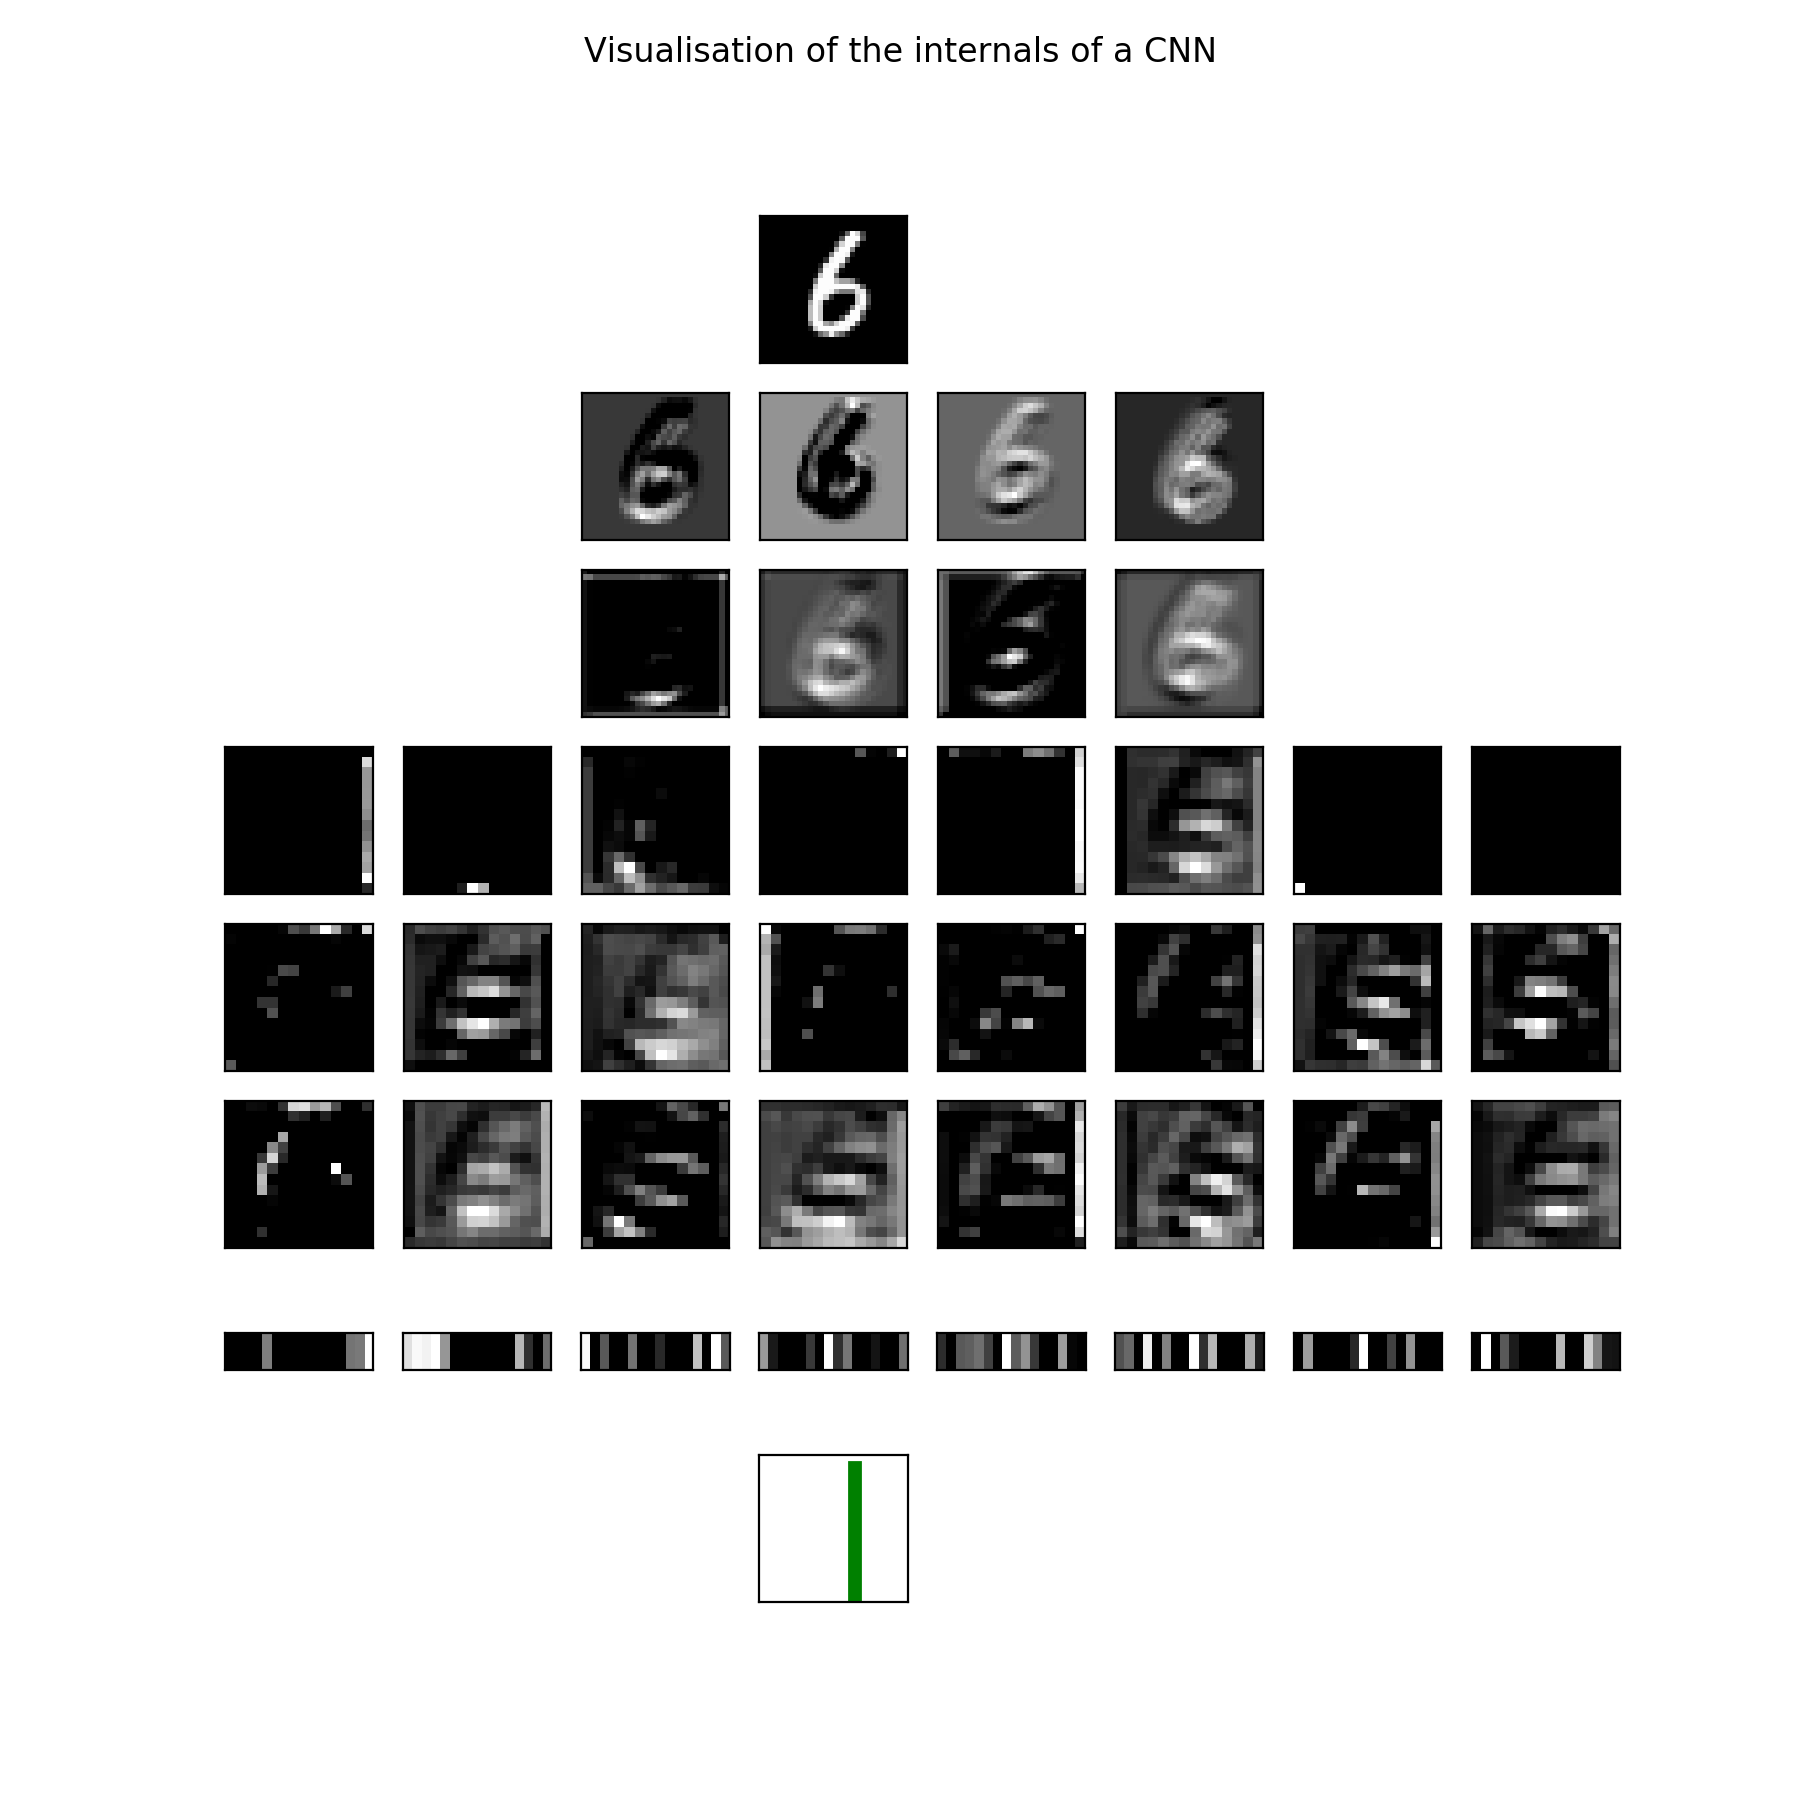

In [31]:
predict(x_test,parameters,y_test)